# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Reframing as a Data Problem

We have historical data of used cars prices with many attributes such as car model, year, condition, cylinders, fuel type, odometer, and many others. Our task is to determine which features impact the price of a car most.
For keeping the task manageable, we would limit identifying at most four features that impact the price the most.

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

import numpy as np
import plotly.express as px
import pandas as pd
import math

import warnings
warnings.filterwarnings("ignore")

In [110]:
vehicles_df = pd.read_csv('/Users/dsgarcha/Downloads/practical_application_II_starter/data/vehicles.csv')
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [111]:
vehicles_df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [112]:
vehicles_df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


<Axes: >

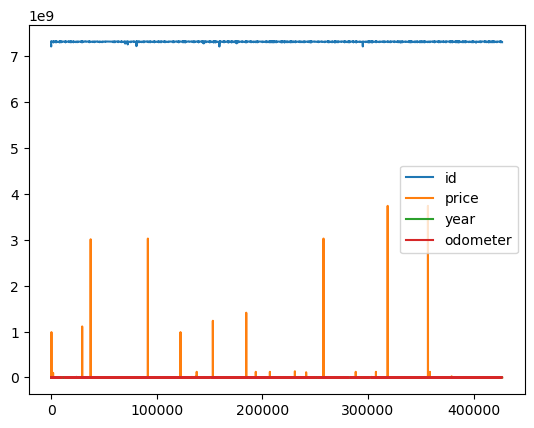

In [113]:
vehicles_df.plot()

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [114]:
# Dropping unnecessary columns, as explained in the README
vehicles = vehicles_df[['price', 'year', 'manufacturer', 'condition', 'cylinders', 'odometer', 'type']].convert_dtypes()
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         426880 non-null  Int64 
 1   year          425675 non-null  Int64 
 2   manufacturer  409234 non-null  string
 3   condition     252776 non-null  string
 4   cylinders     249202 non-null  string
 5   odometer      422480 non-null  Int64 
 6   type          334022 non-null  string
dtypes: Int64(3), string(4)
memory usage: 24.0 MB


In [115]:
vehicles.describe(include = ['string'])

,manufacturer,condition,cylinders,type
count,409234,252776,249202,334022
unique,42,6,8,13
top,ford,good,6 cylinders,sedan
freq,70985,121456,94169,87056


In [116]:
vehicles['manufacturer'].unique()

<StringArray>
[             <NA>,             'gmc',       'chevrolet',          'toyota',
            'ford',            'jeep',          'nissan',             'ram',
           'mazda',        'cadillac',           'honda',           'dodge',
           'lexus',          'jaguar',           'buick',        'chrysler',
           'volvo',            'audi',        'infiniti',         'lincoln',
      'alfa-romeo',          'subaru',           'acura',         'hyundai',
   'mercedes-benz',             'bmw',      'mitsubishi',      'volkswagen',
         'porsche',             'kia',           'rover',         'ferrari',
            'mini',         'pontiac',            'fiat',           'tesla',
          'saturn',         'mercury', 'harley-davidson',          'datsun',
    'aston-martin',      'land rover',          'morgan']
Length: 43, dtype: string

In [117]:
vehicles['condition'].unique()

<StringArray>
[<NA>, 'good', 'excellent', 'fair', 'like new', 'new', 'salvage']
Length: 7, dtype: string

In [118]:
vehicles['cylinders'].unique()

<StringArray>
[          <NA>,  '8 cylinders',  '6 cylinders',  '4 cylinders',
  '5 cylinders',        'other',  '3 cylinders', '10 cylinders',
 '12 cylinders']
Length: 9, dtype: string

In [119]:
vehicles['type'].unique()

<StringArray>
[         <NA>,      'pickup',       'truck',       'other',       'coupe',
         'SUV',   'hatchback',    'mini-van',       'sedan',     'offroad',
         'bus',         'van', 'convertible',       'wagon']
Length: 14, dtype: string

In [120]:
vehicles = vehicles[['price', 'year', 'condition', 'odometer']]

In [121]:
vehicles.dropna(inplace=True)
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250851 entries, 27 to 426879
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   price      250851 non-null  Int64 
 1   year       250851 non-null  Int64 
 2   condition  250851 non-null  string
 3   odometer   250851 non-null  Int64 
dtypes: Int64(3), string(1)
memory usage: 10.3 MB


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [122]:
X = vehicles.drop('price', axis=1)
y = vehicles['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22, test_size=.3)


In [123]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75256 entries, 79982 to 173982
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       75256 non-null  Int64 
 1   condition  75256 non-null  string
 2   odometer   75256 non-null  Int64 
dtypes: Int64(2), string(1)
memory usage: 2.4 MB


In [124]:
oe = OrdinalEncoder(categories = [['salvage', 'fair', 'good', 'excellent', 'like new', 'new']])
xt2 = oe.fit_transform(X_train[['condition']])
#X_train['condition'].head()
print(xt2)


[[2.]
 [2.]
 [3.]
 ...
 [5.]
 [2.]
 [2.]]


In [125]:
X_train.head()

,year,condition,odometer
332313,2020,good,10688
288713,2020,good,16400
279055,2012,excellent,79310
183991,2009,good,137000
148861,1999,good,169898


In [126]:
oe_transformer = make_column_transformer((oe, ['condition']), 
                                          remainder='passthrough')
oe_transformer.fit_transform(X_train[['condition']])

pipe = Pipeline([('oe_transformer', oe_transformer), ('linear_model', LinearRegression())])
pipe.fit(X_train, y_train)


Pipeline(steps=[('oe_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['salvage',
                                                                              'fair',
                                                                              'good',
                                                                              'excellent',
                                                                              'like '
                                                                              'new',
                                                                              'new']]),
                                                  ['condition'])])),
                ('linear_model', LinearRegression())])

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [128]:
#make predictions on training and test data
train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)
    
#compute mse
train_mse = float(mean_squared_error(y_train, train_preds))
test_mse = float(mean_squared_error(y_test, test_preds))

train_rmse = math.sqrt(train_mse)
test_rmse = math.sqrt(test_mse)

print('Mean square errors on Train Data:',train_mse)
print('Root mean square error on Train Data:',train_rmse)
print('Mean square errors on Test Data:',test_mse)
print('Root mean square error on Test Data:',test_rmse)

Mean square errors on Train Data: 167991254005346.75
Root mean square error on Train Data: 12961144.008356158
Mean square errors on Test Data: 17069807058184.562
Root mean square error on Test Data: 4131562.302348176


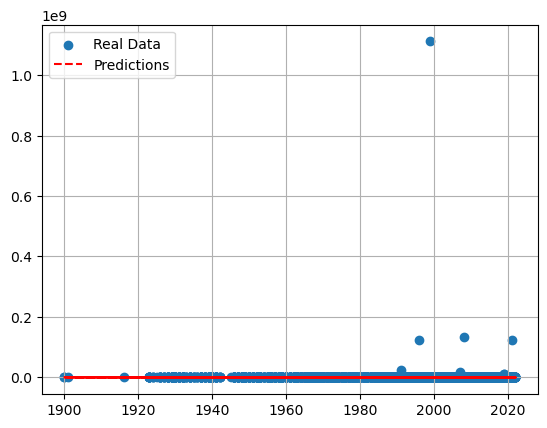

In [138]:
Xnp = X_test['year'].to_numpy()
plt.scatter(Xnp, y_test, label = 'Real Data')
plt.plot(Xnp, test_preds, 'r--', label = 'Predictions')
plt.legend()
plt.grid();

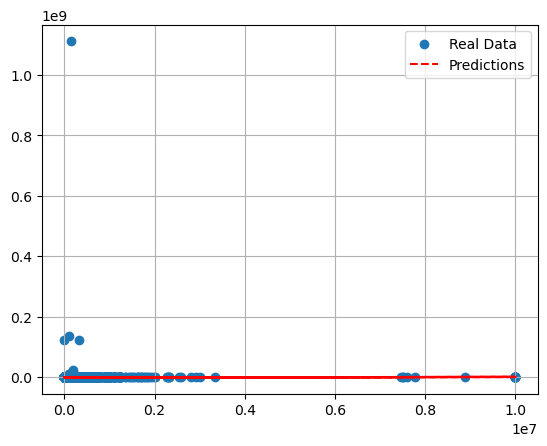

In [140]:
Xnp = X_test['odometer'].to_numpy()
plt.scatter(Xnp, y_test, label = 'Real Data')
plt.plot(Xnp, test_preds, 'r--', label = 'Predictions')
plt.legend()
plt.grid();

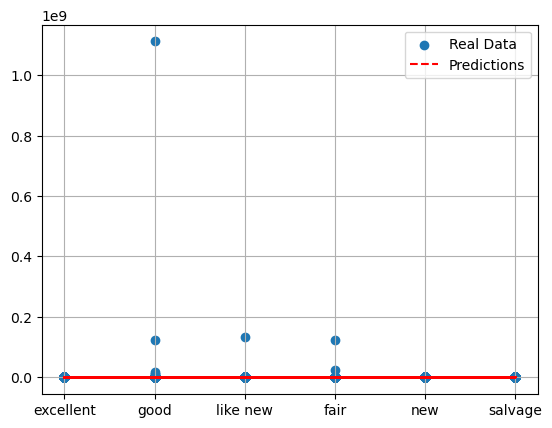

In [141]:
Xnp = X_test['condition'].to_numpy()
plt.scatter(Xnp, y_test, label = 'Real Data')
plt.plot(Xnp, test_preds, 'r--', label = 'Predictions')
plt.legend()
plt.grid();

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.